## Subreddit Identification Model##

#### Note: The CSV file was previously created in the 'Reddit_Creating_CSV' notebook

The goal of this project is to create a model that can take in a reddit post, and accurately categorize the subreddit it belongs to. 

The two subreddits I will be using for this are Cinematography, and Photography. These are broad enough to gather a large variety of information, have some intersecting topics, but are unique enough that we should be able to determine with a level of certainty which subreddit a post originated from. We will also be taking a look at what kinds of posts are most difficult to classify.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
import nltk
#prompted from error code during model fitting process  

In [3]:
#Read in the DataFrame:

reddit = pd.read_csv('cine_photo.csv')
reddit.head()

,title,score,id,url,comms_num,created,body,subreddit
0,Megathread Monday October 19 2020: There are n...,2,jdzmm0,https://www.reddit.com/r/cinematography/commen...,3,1.603134e+09,"Ask your questions, no matter how big or small...",Cinematography
1,Our 2 person Director/DP team (plus a helicopt...,735,je4tlf,https://www.reddit.com/gallery/je4tlf,84,1.603153e+09,NaN,Cinematography
2,the way they shot this is AMAZING. 😳😳😳 I'm pos...,13,jediiz,https://v.redd.it/krk601q7y4u51,4,1.603179e+09,NaN,Cinematography
3,Tried some things out with a practical lens test,2,jehwkz,https://www.reddit.com/gallery/jehwkz,1,1.603194e+09,NaN,Cinematography
4,Went for a vintage look with this music video ...,5,jeb6lf,https://youtu.be/gwM_SbjD_Ho,2,1.603171e+09,NaN,Cinematography


### Data cleaning

In [5]:
reddit.isnull().sum()

title          0
score          0
id             0
url            0
comms_num      0
created        0
body         526
subreddit      0
dtype: int64

These subreddits rely on visuals, and because of that some posts have a title, but no body test. I an going to combine the title and body columns into one text column to use for my analysis, so I do not have to drop any rows.

In [4]:
reddit['body'] = reddit['body'].fillna(' ')

In [5]:
reddit['text'] = reddit['title'] + ' ' + reddit['body']

In [8]:
reddit.head()

,title,score,id,url,comms_num,created,body,subreddit,text
0,Megathread Monday October 19 2020: There are n...,2,jdzmm0,https://www.reddit.com/r/cinematography/commen...,3,1.603134e+09,"Ask your questions, no matter how big or small...",Cinematography,Megathread Monday October 19 2020: There are n...
1,Our 2 person Director/DP team (plus a helicopt...,735,je4tlf,https://www.reddit.com/gallery/je4tlf,84,1.603153e+09,,Cinematography,Our 2 person Director/DP team (plus a helicopt...
2,the way they shot this is AMAZING. 😳😳😳 I'm pos...,13,jediiz,https://v.redd.it/krk601q7y4u51,4,1.603179e+09,,Cinematography,the way they shot this is AMAZING. 😳😳😳 I'm pos...
3,Tried some things out with a practical lens test,2,jehwkz,https://www.reddit.com/gallery/jehwkz,1,1.603194e+09,,Cinematography,Tried some things out with a practical lens te...
4,Went for a vintage look with this music video ...,5,jeb6lf,https://youtu.be/gwM_SbjD_Ho,2,1.603171e+09,,Cinematography,Went for a vintage look with this music video ...


In [6]:
reddit = reddit.drop(columns = ['title', 'id', 'url',
                                  'created', 'body'])

In [7]:
reddit.head()

,score,comms_num,subreddit,text
0,2,3,Cinematography,Megathread Monday October 19 2020: There are n...
1,735,84,Cinematography,Our 2 person Director/DP team (plus a helicopt...
2,13,4,Cinematography,the way they shot this is AMAZING. 😳😳😳 I'm pos...
3,2,1,Cinematography,Tried some things out with a practical lens te...
4,5,2,Cinematography,Went for a vintage look with this music video ...


In [8]:
#binarize the subreddit column

reddit['subreddit'] = reddit['subreddit'].map({'Photography': 0, 'Cinematography': 1})

In [22]:
#removing punctuation before using cvec

reddit['text'] = reddit['text'].str.replace('\d+', '') # for digits
reddit['text'] = reddit['text'].str.replace(r'(\b\w{1,2}\b)', '') # for words
reddit['text'] = reddit['text'].str.replace('[^\w\s]', '') # for punctuation 

#https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer

### Data visualizations

In [23]:
cine = reddit[reddit['subreddit'] == 1]
photo = reddit[reddit['subreddit'] == 0]

In [20]:
photo.head()

,score,comms_num,subreddit,text
981,120,44,0,Announcement Official photography Discord Serv...
982,24,215,0,Official Question Thread Ask photography anyth...
983,530,245,0,Lightroom Classic released with interesting i...
984,6,3,0,Adobe MAX starts tomorrow and completely free...
985,14,4,0,Interview with Photography Legend Pete Souza J...


In [11]:
print('mean Cinematography score: ', cine.score.mean())
print('mean Photography score: ', photo.score.mean())
print('mean Cinematography comment number: ', cine.comms_num.mean())
print('mean Photography comment number: ', photo.comms_num.mean())
print('Cinematography comment number sum: ', cine.comms_num.sum())
print('Photography comment number sum: ', photo.comms_num.sum())

#Cinematography members: 171k
#Photography members: 3.5m

mean Cinematography score:  49.20183486238532
mean Photography score:  160.0631067961165
mean Cinematography comment number:  8.234454638124364
mean Photography comment number:  62.470873786407765
Cinematography comment number sum:  8078
Photography comment number sum:  12869


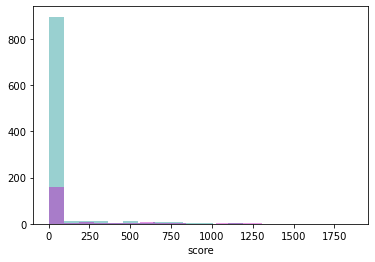

In [12]:
#hist of scores for photo/cine

sns.distplot(cine['score'], color='darkcyan', bins=20, kde=False);
sns.distplot(photo['score'], color='m', bins=20, kde=False);

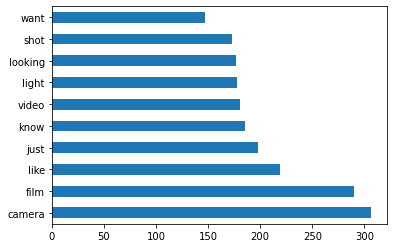

In [24]:
#Top words for cine subreddit:

cvec = CountVectorizer(stop_words = 'english')
cvec.fit(cine['text'])
cine_cv = cvec.transform(cine['text'])

cine_df = pd.DataFrame(cine_cv.todense(), 
                          columns=cvec.get_feature_names())

cine_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh');

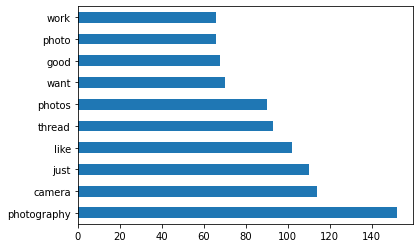

In [25]:
#Top words for photo subreddit:

cvec = CountVectorizer(stop_words = 'english')
cvec.fit(photo['text'])
photo_cv = cvec.transform(photo['text'])

photo_df = pd.DataFrame(photo_cv.todense(), 
                          columns=cvec.get_feature_names())

photo_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh');

In [ ]:
#Four of the top ten words appear in both subreddits. This will limit the accuracy I can achieve with my model.

### Split the data

In [26]:
X = reddit['text']
y = reddit['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                   y, 
                                                   random_state = 42,
                                                   stratify = y)

In [27]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

#count vectorize train and test data
lem_cvec = CountVectorizer(lowercase = True,
                       strip_accents = 'unicode',
                       stop_words = 'english', 
                       tokenizer = LemmaTokenizer()
                       )
lem_cvec.fit(X_train)

#transform train and test
X_train = lem_cvec.transform(X_train)
X_test = lem_cvec.transform(X_test)


#add lemmatizer to CountVec: https://stackoverflow.com/questions/47423854/sklearn-adding-lemmatizer-to-countvectorizer

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"
/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


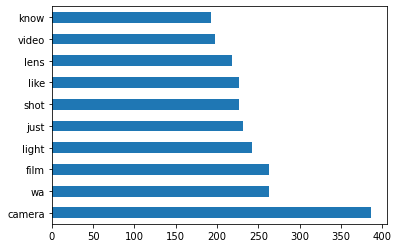

In [28]:
#top words for cine/photo combined df:

X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=lem_cvec.get_feature_names())

# plot
X_train_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh');

In [18]:
y.value_counts(normalize=True)

1    0.826453
0    0.173547
Name: subreddit, dtype: float64

In [19]:
X_train.shape

(890, 5788)

### Model 1: Random Forest classifier

In [29]:
#instantiate model:

rf = RandomForestClassifier(random_state = 42)
#Grid search over below parameters:
params = {
    'n_estimators': [50, 100, 200],
    'max_features':[450, 475, 500, 525],
    'min_samples_leaf': [2]
}

In [61]:
rf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [30]:
rf_gs = GridSearchCV(rf, param_grid = params, cv = 5)
rf_gs.fit(X_train, y_train)
print(rf_gs.best_score_) #cross val score
rf_gs.best_params_

0.9269662921348315


{'max_features': 475, 'min_samples_leaf': 2, 'n_estimators': 50}

In [31]:
preds = rf_gs.predict(X_test)
rf_gs.score(X_test, y_test)

0.9225589225589226

In [42]:
#Will Extra Tree modeling help my score at all?

et = ExtraTreesClassifier(random_state = 42)

et_gs = GridSearchCV(et, param_grid = params, cv = 5)
et_gs.fit(X_train, y_train)
print(et_gs.best_score_)
et_gs.best_params_

0.9224719101123595


{'max_features': 450, 'min_samples_leaf': 2, 'n_estimators': 200}

In [79]:
#Test score

et_preds = et_gs.predict(X_test)
et_gs.score(X_test, y_test)

0.9090909090909091

### Model 2: Bagging

In [43]:
bag = BaggingClassifier(random_state = 42)
bag.fit(X_train, y_train)
bag.score(X_test, y_test)

0.9023569023569024

In [82]:
bag.score(X_train, y_train)
#The best training score, but the most overfit dataset.

0.9898876404494382

### Model 3: SVM

In [44]:
#scale data

ss = StandardScaler(with_mean = False)
ss_X_train = ss.fit_transform(X_train, y_train)

#with mean troubleshooting: https://stackoverflow.com/questions/52008548/python-running-into-x-test-y-test-fit-errors/52009055

In [45]:
pgrid = {"C": np.linspace(0.0001, 1, 10),
        }

In [47]:
svc = LinearSVC(max_iter = 7000)

#shuffling the dataset, because it is ordered as one subreddit and then the other in the original CSV file and df
cv_folds = StratifiedKFold(shuffle = True, random_state = 42)
gs = GridSearchCV(svc, pgrid, cv = cv_folds)
gs.fit(ss_X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LinearSVC(max_iter=15000),
             param_grid={'C': array([1.000e-04, 1.112e-01, 2.223e-01, 3.334e-01, 4.445e-01, 5.556e-01,
       6.667e-01, 7.778e-01, 8.889e-01, 1.000e+00])})

In [48]:
gs.best_params_

{'C': 0.11120000000000001}

In [49]:
gs.best_score_

0.8707865168539325

In [83]:
preds = gs.predict(X_test)
gs.score(X_test, y_test)

0.8249158249158249

The best model was Ramdom Forest modeling, without ExtraTrees. I ended with a test score .9225, and given the limitations of two similar subreddits, I am pleased with the results.

### Which posts could not be classified?

In [32]:
#Creating a dataframe of misclassified texts, 
results = pd.DataFrame({'predicted': preds,
                       'actual': y_test})
indices = results[results['predicted'] != results['actual']].index

#referenced in lesson 6.05: Lesson Support Vector Machines

In [33]:
indices

Int64Index([1070, 1153,  994, 1001, 1035, 1039, 1018, 1115,  851,  710,  619,
            1112, 1080, 1141, 1160, 1111, 1150, 1102, 1186, 1132,  606, 1162,
            1064],
           dtype='int64')

In [37]:
# Posts that could not be predicted
reddit['text'].iloc[1132]

' Fall Foliage Map amp Nationwide Peak Leaf Forecast  '

In [40]:
reddit['text'].iloc[1064]

'Why   few cameras provide Geotagging   just wondering why  not built into any higher grade cameras  can not find any decent new mirror less camera that has Geotagging  would  awesome for travelling'

In [62]:
reddit['text'].iloc[606]

'Why   lot  popular DPs have  still photography  their websites There seems    affinity   lot  the DPs  like shooting  still photography \n\nhttpsrinayangcomstills\n\nDeakins prefers   well\n\nJust some examples totally aware  the color  her page too Idk maybe  brain  making connections that don actually matter \n\nThank you'

The examples above really highlight the limitations of the model. There are examples that even a human wouldn't be able to classify due to lack of context, and examples where context allows us to make assumptions, but the key words we use overlap each subreddit. Idealy with a larger dataset we could weed out some of the errors, but it is unlikely a model could have 100% accuracy on testing data.